# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [2]:
summary = pd.DataFrame(columns=['test_accuracy', 'test_roc_auc', 'test_f1', 'test_average_precision'])
summary.index.name = 'method_name'

## Choose the model

In [45]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)

from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=6, n_estimators=500)

## Get the data

In [4]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

In [5]:
# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_artefact)

,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [6]:
def get_X_and_y(impact, features, categorical_features):
    data = impact.copy()
    data = data[features + ['is_artefact']]
    
    # transform categorical features
    numerical_features = [f for f in features if not f in categorical_features]
    data = pd.get_dummies(data, columns=categorical_features, sparse=True)

    # get reduced dataset
    positive_class_number = data[data.is_artefact].shape[0]
    data = pd.concat([data[data.is_artefact],
                        data[~data.is_artefact].iloc[:positive_class_number]], ignore_index=True)

    # shuffle data
    rng = np.random.RandomState(42)
    permutation = rng.permutation(len(data))
    data = data.iloc[permutation]
    data.reset_index(drop=True, inplace=True)

    # get features matrix X (n_samples x n_features) and target array y (n_samples)
    X = data.drop('is_artefact', axis=1)
    X = X.astype(float)
    y = data['is_artefact']

    get_table(y)
    
    return X, y

## No feature processing

In [7]:
features = [
#'Hugo_Symbol',
#'Chromosome',
#'Start_Position',
#'End_Position',
#'Consequence',
#'Variant_Type',
#'Reference_Allele',
#'Tumor_Seq_Allele2',
#'Tumor_Sample_Barcode',
#'cDNA_change',
#'HGVSp_Short',
't_depth',
't_vaf',
't_alt_count',
'n_depth',
'n_vaf',
'n_alt_count',
#'t_ref_plus_count',
#'t_ref_neg_count',
#'t_alt_plus_count',
#'t_alt_neg_count',
#'confidence_class',
'sample_coverage',
#'mut_key',
#'VAG_VT',
#'VAG_GENE',
#'VAG_cDNA_CHANGE',
#'VAG_PROTEIN_CHANGE',
#'VAG_EFFECT',
'VEP_Consequence',
#'VEP_SYMBOL',
#'VEP_HGVSc',
#'VEP_HGVSp',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
#'VEP_EXON',
#'VEP_INTRON',
'VEP_IMPACT',
'VEP_CLIN_SIG',
'VEP_COSMIC_CNT',
'VEP_gnomAD_AF',
#'sample_mut_key',
#'patient_key',
'frequency_in_normals',
#'VEP_SIFT_class',
#'VEP_SIFT_score',
#'VEP_PolyPhen_class',
#'VEP_PolyPhen_score',
'VEP_in_dbSNP',
'VEP_gnomAD_total_AF_AFR',
'VEP_gnomAD_total_AF_AMR',
'VEP_gnomAD_total_AF_ASJ',
'VEP_gnomAD_total_AF_EAS',
'VEP_gnomAD_total_AF_FIN',
'VEP_gnomAD_total_AF_NFE',
'VEP_gnomAD_total_AF_OTH',
'VEP_gnomAD_total_AF_max',
'VEP_gnomAD_total_AF',
'Kaviar_AF',
#'is_a_hotspot',
#'is_a_3d_hotspot',
#'oncogenic',
'gene_type',
#'is_artefact'
]

# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']

In [8]:
features

['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'n_vaf',
 'n_alt_count',
 'sample_coverage',
 'VEP_Consequence',
 'VEP_VARIANT_CLASS',
 'VEP_IMPACT',
 'VEP_CLIN_SIG',
 'VEP_COSMIC_CNT',
 'VEP_gnomAD_AF',
 'frequency_in_normals',
 'VEP_in_dbSNP',
 'VEP_gnomAD_total_AF_AFR',
 'VEP_gnomAD_total_AF_AMR',
 'VEP_gnomAD_total_AF_ASJ',
 'VEP_gnomAD_total_AF_EAS',
 'VEP_gnomAD_total_AF_FIN',
 'VEP_gnomAD_total_AF_NFE',
 'VEP_gnomAD_total_AF_OTH',
 'VEP_gnomAD_total_AF_max',
 'VEP_gnomAD_total_AF',
 'Kaviar_AF',
 'gene_type']

In [9]:
X, y = get_X_and_y(impact, features, categorical_features)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done! (40.72s)
▴ Mean accuracy    : 0.886 ± 0.004
▴ Mean ROC AUC     : 0.953 ± 0.005
▴ Mean F1-score    : 0.883 ± 0.004
▴ Average precision: 0.960 ± 0.004


In [10]:
summary.loc['no_processing'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Without GnomAD populations

In [11]:
features = ['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'n_vaf',
 'n_alt_count',
 'sample_coverage',
 'VEP_Consequence',
 'VEP_VARIANT_CLASS',
 'VEP_IMPACT',
 'VEP_CLIN_SIG',
 'VEP_COSMIC_CNT',
 'VEP_gnomAD_AF',
 'frequency_in_normals',
 'VEP_in_dbSNP',
 'VEP_gnomAD_total_AF_max',
 'VEP_gnomAD_total_AF',
 'Kaviar_AF',
 'gene_type']

In [12]:
X, y = get_X_and_y(impact, features, categorical_features)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done! (39.44s)
▴ Mean accuracy    : 0.887 ± 0.008
▴ Mean ROC AUC     : 0.953 ± 0.005
▴ Mean F1-score    : 0.884 ± 0.008
▴ Average precision: 0.960 ± 0.004


In [13]:
summary.loc['without_gnomAD_populations'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Without `VEP_Consequence`, `VEP_IMPACT`, `VEP_CLIN_SIG`, `VEP_in_dbSNP`, `n_vaf`, `n_alt_count`

In [14]:
features = ['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'sample_coverage',
 'VEP_VARIANT_CLASS',
 'VEP_COSMIC_CNT',
 'VEP_gnomAD_AF',
 'frequency_in_normals',
 'VEP_gnomAD_total_AF_max',
 'VEP_gnomAD_total_AF',
 'Kaviar_AF',
 'gene_type']
categorical_features=['gene_type', 'VEP_VARIANT_CLASS']

In [15]:
X, y = get_X_and_y(impact, features, categorical_features)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done! (34.57s)
▴ Mean accuracy    : 0.884 ± 0.008
▴ Mean ROC AUC     : 0.952 ± 0.004
▴ Mean F1-score    : 0.881 ± 0.010
▴ Average precision: 0.959 ± 0.004


In [16]:
summary.loc['without_VEP_additional_info'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Without `VEP_gnomAD_AF`, `Kaviar_AF`

In [17]:
features = ['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'sample_coverage',
 'VEP_VARIANT_CLASS',
 'VEP_COSMIC_CNT',
 'frequency_in_normals',
 'VEP_gnomAD_total_AF_max',
 'VEP_gnomAD_total_AF',
 'gene_type']
categorical_features=['VEP_VARIANT_CLASS', 'gene_type']

In [18]:
X, y = get_X_and_y(impact, features, categorical_features)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done! (43.24s)
▴ Mean accuracy    : 0.880 ± 0.006
▴ Mean ROC AUC     : 0.951 ± 0.005
▴ Mean F1-score    : 0.876 ± 0.007
▴ Average precision: 0.958 ± 0.003


In [19]:
summary.loc['without_VEP_additional_info_2'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Simplify `VEP_VARIANT_CLASS`

In [20]:
impact['is_SNV'] = (impact.VEP_VARIANT_CLASS == 'SNV')

In [21]:
features = ['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'sample_coverage',
 'is_SNV',
 'VEP_COSMIC_CNT',
 'frequency_in_normals',
 'VEP_gnomAD_total_AF_max',
 'VEP_gnomAD_total_AF',
 'gene_type']
categorical_features=['gene_type']

In [22]:
X, y = get_X_and_y(impact, features, categorical_features)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done! (33.61s)
▴ Mean accuracy    : 0.883 ± 0.008
▴ Mean ROC AUC     : 0.950 ± 0.006
▴ Mean F1-score    : 0.880 ± 0.010
▴ Average precision: 0.957 ± 0.004


In [23]:
summary.loc['simplified_VEP_VARIANT_CLASS'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Tried

In [24]:
populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']
impact['population_number'] = impact.apply(lambda x: sum(x[populations] != 0), axis=1)

In [25]:
get_table(impact['population_number'])

,count_,freq_
0,154778,79.7%
1,21199,10.9%
2,7665,3.9%
3,4271,2.2%
4,2009,1.0%
7,1826,0.9%
6,1237,0.6%
5,1226,0.6%


In [26]:
impact['is_frequent_in_population'] = impact['population_number'] >= 3

In [27]:
impact['strand_ratio'] = impact[['t_alt_neg_count', 't_alt_plus_count']].min(axis=1) / impact[['t_alt_neg_count', 't_alt_plus_count']].max(axis=1)

Every unselected features tried and useless.

## Add `Chromosome`

In [28]:
features = ['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'sample_coverage',
 'is_SNV',
 'VEP_COSMIC_CNT',
 'frequency_in_normals',
 'VEP_gnomAD_total_AF_max',
 'VEP_gnomAD_total_AF',
 'Chromosome']

categorical_features = ['Chromosome']

In [29]:
X, y = get_X_and_y(impact, features, categorical_features)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done! (33.59s)
▴ Mean accuracy    : 0.884 ± 0.005
▴ Mean ROC AUC     : 0.952 ± 0.006
▴ Mean F1-score    : 0.881 ± 0.005
▴ Average precision: 0.959 ± 0.005


In [31]:
summary.loc['add_chromosome'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Study feature importance

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

model.fit(X, y);

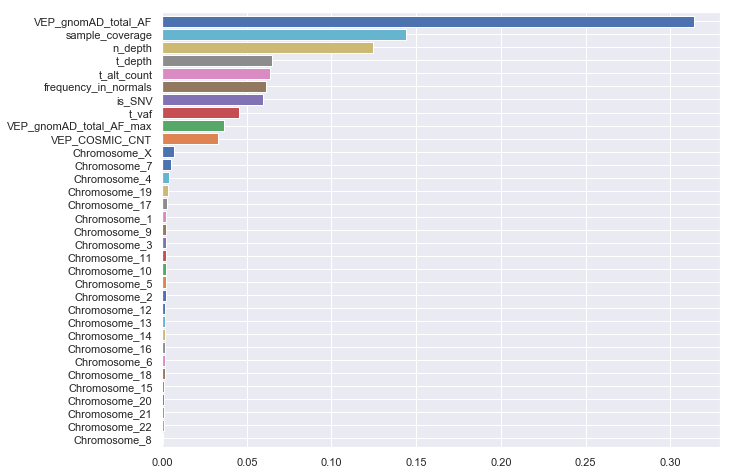

In [33]:
feature_importance = pd.DataFrame({'value': model.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

plt.figure(figsize = (10, 8))
feature_importance.value.plot.barh(width=0.85);

## Summary

,test_accuracy,test_roc_auc,test_f1,test_average_precision
method_name,,,,
no_processing,0.886,0.953,0.883,0.96
without_gnomAD_populations,0.887,0.953,0.884,0.96
without_VEP_additional_info,0.884,0.952,0.881,0.959
without_VEP_additional_info_2,0.88,0.951,0.876,0.958
simplified_VEP_VARIANT_CLASS,0.883,0.95,0.88,0.957
add_chromosome,0.884,0.952,0.881,0.959


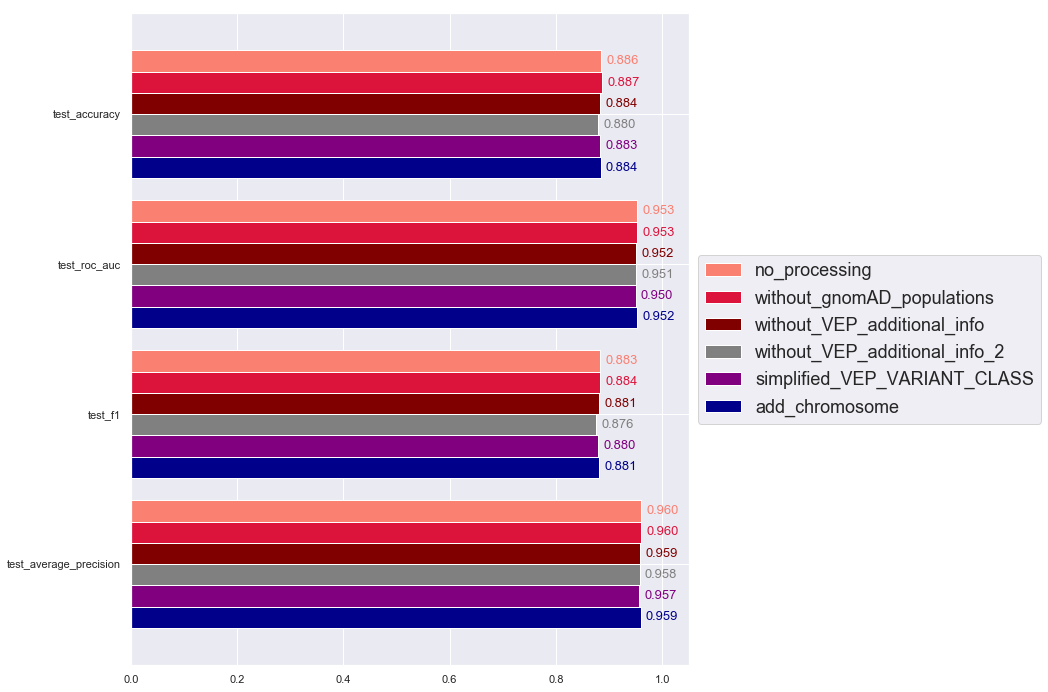

In [34]:
compare_models(summary)

In [35]:
features

['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'sample_coverage',
 'is_SNV',
 'VEP_COSMIC_CNT',
 'frequency_in_normals',
 'VEP_gnomAD_total_AF_max',
 'VEP_gnomAD_total_AF',
 'Chromosome']

## Test

In [36]:
features = ['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'sample_coverage',
 'is_SNV',
 'VEP_COSMIC_CNT',
 'frequency_in_normals',
 'Chromosome']

categorical_features = ['Chromosome']

In [37]:
X, y = get_X_and_y(impact, features, categorical_features)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done! (31.30s)
▴ Mean accuracy    : 0.870 ± 0.004
▴ Mean ROC AUC     : 0.944 ± 0.006
▴ Mean F1-score    : 0.867 ± 0.005
▴ Average precision: 0.951 ± 0.003


In [38]:
from sklearn.ensemble import GradientBoostingClassifier

model.fit(X, y);

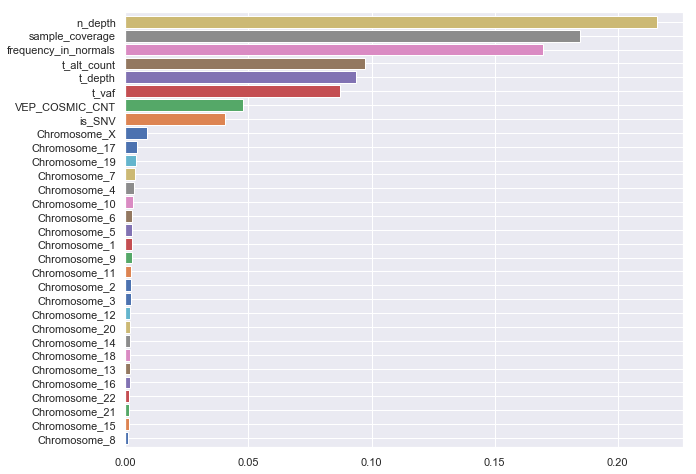

In [39]:
feature_importance = pd.DataFrame({'value': model.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

plt.figure(figsize = (10, 8))
feature_importance.value.plot.barh(width=0.85);

## LogisticRegression and RandomForest before and after

In [46]:
from sklearn.ensemble import RandomForestClassifier
model_RandomForest = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=30, n_estimators=1000)

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
nested_cv_strategy = StratifiedKFold(n_splits=3)
model_LogisticRegressionGS = Pipeline([('scale'   , StandardScaler()),
                                       ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])

from sklearn.svm import SVC
model_SVM = Pipeline([('scale'   , StandardScaler()),
                      ('classify', SVC(probability=True, cache_size=1000, gamma='scale', C=10, kernel='rbf'))])

In [47]:
features = [
#'Hugo_Symbol',
#'Chromosome',
#'Start_Position',
#'End_Position',
#'Consequence',
#'Variant_Type',
#'Reference_Allele',
#'Tumor_Seq_Allele2',
#'Tumor_Sample_Barcode',
#'cDNA_change',
#'HGVSp_Short',
't_depth',
't_vaf',
't_alt_count',
'n_depth',
'n_vaf',
'n_alt_count',
#'t_ref_plus_count',
#'t_ref_neg_count',
#'t_alt_plus_count',
#'t_alt_neg_count',
#'confidence_class',
'sample_coverage',
#'mut_key',
#'VAG_VT',
#'VAG_GENE',
#'VAG_cDNA_CHANGE',
#'VAG_PROTEIN_CHANGE',
#'VAG_EFFECT',
'VEP_Consequence',
#'VEP_SYMBOL',
#'VEP_HGVSc',
#'VEP_HGVSp',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
#'VEP_EXON',
#'VEP_INTRON',
'VEP_IMPACT',
'VEP_CLIN_SIG',
'VEP_COSMIC_CNT',
'VEP_gnomAD_AF',
#'sample_mut_key',
#'patient_key',
'frequency_in_normals',
#'VEP_SIFT_class',
#'VEP_SIFT_score',
#'VEP_PolyPhen_class',
#'VEP_PolyPhen_score',
'VEP_in_dbSNP',
'VEP_gnomAD_total_AF_AFR',
'VEP_gnomAD_total_AF_AMR',
'VEP_gnomAD_total_AF_ASJ',
'VEP_gnomAD_total_AF_EAS',
'VEP_gnomAD_total_AF_FIN',
'VEP_gnomAD_total_AF_NFE',
'VEP_gnomAD_total_AF_OTH',
'VEP_gnomAD_total_AF_max',
'VEP_gnomAD_total_AF',
'Kaviar_AF',
#'is_a_hotspot',
#'is_a_3d_hotspot',
#'oncogenic',
'gene_type',
#'is_artefact'
]

categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']

In [48]:
X_old, y_old = get_X_and_y(impact, features, categorical_features)

In [49]:
features = ['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'sample_coverage',
 'is_SNV',
 'VEP_COSMIC_CNT',
 'frequency_in_normals',
 'VEP_gnomAD_total_AF_max',
 'VEP_gnomAD_total_AF',
 'Chromosome']

categorical_features = ['Chromosome']

In [50]:
X_new, y_new = get_X_and_y(impact, features, categorical_features)

**RandomForest**

In [51]:
metrics = run_model(model_RandomForest, X_old, y_old, cv_strategy, n_jobs=20)
print_mean_metrics(metrics)
metrics = run_model(model_RandomForest, X_new, y_new, cv_strategy, n_jobs=20)
print_mean_metrics(metrics)

Run model... done! (144.24s)
▴ Mean accuracy    : 0.863 ± 0.009
▴ Mean ROC AUC     : 0.937 ± 0.008
▴ Mean F1-score    : 0.858 ± 0.009
▴ Average precision: 0.947 ± 0.007
Run model... done! (58.01s)
▴ Mean accuracy    : 0.866 ± 0.006
▴ Mean ROC AUC     : 0.938 ± 0.006
▴ Mean F1-score    : 0.861 ± 0.006
▴ Average precision: 0.949 ± 0.006


**Logistic Regression**

In [52]:
metrics = run_model(model_LogisticRegressionGS, X_old, y_old, cv_strategy, n_jobs=20)
print_mean_metrics(metrics)
metrics = run_model(model_LogisticRegressionGS, X_new, y_new, cv_strategy, n_jobs=20)
print_mean_metrics(metrics)

Run model... done! (4.46s)
▴ Mean accuracy    : 0.820 ± 0.006
▴ Mean ROC AUC     : 0.891 ± 0.010
▴ Mean F1-score    : 0.803 ± 0.011
▴ Average precision: 0.912 ± 0.006
Run model... done! (2.48s)
▴ Mean accuracy    : 0.809 ± 0.012
▴ Mean ROC AUC     : 0.885 ± 0.009
▴ Mean F1-score    : 0.792 ± 0.017
▴ Average precision: 0.906 ± 0.006


**SVM**

In [53]:
metrics = run_model(model_SVM, X_old, y_old, cv_strategy, n_jobs=20)
print_mean_metrics(metrics)
metrics = run_model(model_SVM, X_new, y_new, cv_strategy, n_jobs=20)
print_mean_metrics(metrics)

Run model... done! (66.81s)
▴ Mean accuracy    : 0.838 ± 0.011
▴ Mean ROC AUC     : 0.913 ± 0.009
▴ Mean F1-score    : 0.825 ± 0.012
▴ Average precision: 0.927 ± 0.007
Run model... done! (58.76s)
▴ Mean accuracy    : 0.829 ± 0.008
▴ Mean ROC AUC     : 0.908 ± 0.008
▴ Mean F1-score    : 0.818 ± 0.007
▴ Average precision: 0.923 ± 0.007
